# Part 6. DEAP Dataset + LSTM

In this part 6, we shall start using deap learning techniques which is different from the traditional machine learning approaches in the sense that deep learning techniques are able to automatically learn useful features for the task.  In a more simple words, we can directly feed the raw data into deep learning model, and the model should be able to give reasonable accuracy.

In this part, we shall explore LSTM which is a very common model for handling sequential data.

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader

import os
import pickle
import numpy as np

Set cuda accordingly.

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("Configured device: ", device)

Configured device:  cuda


## 1. Loading dataset

Let's first reuse the dataset loader we have created in Part 1.

In [3]:
class Dataset(torch.utils.data.Dataset):
    
    def __init__(self, path):
        _, _, filenames = next(os.walk(path))
        filenames = sorted(filenames)
        all_data = []
        all_label = []
        for dat in filenames:
            
            temp = pickle.load(open(os.path.join(path,dat), 'rb'), encoding='latin1')
            all_data.append(temp['data'])
            
            #####divide labels into four classes: LALV, HALV, LAHV, HAHV
            labels = temp['labels']
            labels_holder = np.zeros((40, 1))
            
            val_med = np.median(labels[:, 0])
            aro_med = np.median(labels[:, 1])

            cond_lalv = (labels[:, 0] <= val_med) & (labels[:, 1] <= aro_med)
            cond_halv = (labels[:, 0] <= val_med) & (labels[:, 1] >= aro_med)
            cond_lahv = (labels[:, 0] >= val_med) & (labels[:, 1] <= aro_med)
            cond_hahv = (labels[:, 0] >= val_med) & (labels[:, 1] >= aro_med)
            
            labels_holder[cond_lalv] = 0  #LALV
            labels_holder[cond_halv] = 1  #HALV
            labels_holder[cond_lahv] = 2  #LAHV
            labels_holder[cond_hahv] = 3  #HAHV
                                    
            #labels_holder shape: (40, 1)
            all_label.append(labels_holder)
                
        self.data = np.vstack(all_data)[:, :32, ]   #shape: (1280, 32, 8064) --> take only the first 32 channels
        self.label = np.vstack(all_label) #(1280, 1)  ==> 1280 samples, 
        
        del temp, all_data, all_label

    def __len__(self):
        return self.data.shape[0]

    def __getitem__(self, idx):
        single_data  = self.data[idx]
        single_label = self.label[idx]
        
        batch = {
            'data' : torch.Tensor(single_data),
            'label': torch.Tensor(single_label)
        }
        
        return batch

Let's try load the dataset.

In [4]:
path = "data"  #create a folder "data", and inside put s01.dat,....,s32.dat inside from the preprocessed folder from the DEAP dataset

In [5]:
dataset = Dataset(path)

data  = dataset[:]['data']
label = dataset[:]['label']

print("Data shape: " , data.shape)  #1280 = 32 * 40 trials, 32 EEG channels, 8064 samples
print("Label shape: ", label.shape)  #four classes of LALV, HALV, LAHV, HAHV

Data shape:  torch.Size([1280, 32, 8064])
Label shape:  torch.Size([1280, 1])


Let's look the label distribution of the dataset.

In [6]:
lalv = label == 0
halv = label == 1
lahv = label == 2
hahv = label == 3

assert len(label[lalv]) + len(label[halv]) + len(label[lahv]) + len(label[hahv]) == label.shape[0]  #simple unit test
print("count of LALV: ", len(label[lalv]))
print("count of HALV: ", len(label[halv]))
print("count of LAHV: ", len(label[lahv]))
print("count of HAHV: ", len(label[hahv]))

count of LALV:  344
count of HALV:  285
count of LAHV:  281
count of HAHV:  370


Let's see the median of EEG of each group (you can do std on your own exercise)

In [7]:
lalv_unsqueeze = lalv.squeeze()
halv_unsqueeze = halv.squeeze()
lahv_unsqueeze = lahv.squeeze()
hahv_unsqueeze = hahv.squeeze()

print("Median of LALV", np.median(data[lalv_unsqueeze, :, :]))
print("Median of HALV", np.median(data[halv_unsqueeze, :, :]))
print("Median of LAHV", np.median(data[lahv_unsqueeze, :, :]))
print("Median of HAHV", np.median(data[hahv_unsqueeze, :, :]))

Median of LALV 0.008621817
Median of HALV 0.008139102
Median of LAHV 0.0065687215
Median of HAHV 0.0016776982


## 2. Defining the Model -> LSTM

Long Short Term Memory is a very simple model which treats data as sequence.  For sequential data such as EEG signal, LSTM (or other variants of recurrent neural network such as vanilla RNN or GRU) is one promising option.

Here, we shall try bidirectional LSTM with two layers and see whether we could get decent accuracies.

In [8]:
class LSTM(nn.Module):
    '''
    Expected Input Shape: (batch, seq_len, channels)
    '''
    def __init__(self, input_dim, hidden_dim, num_layers, output_dim, bidirectional, dropout):
        super().__init__()
        self.lstm = nn.LSTM(input_dim, 
                           hidden_dim, 
                           num_layers=num_layers, 
                           bidirectional=bidirectional, 
                           dropout=dropout,
                           batch_first=True)
        self.fc = nn.Linear(hidden_dim * num_layers, output_dim)
        
    def forward(self, x):
        
        #x = [batch size, seq len, channels]
        out, (hn, cn) = self.lstm(x)
        
        #out = [batch size, seq len, hidden dim * num directions]        
        #hn = [num layers * num directions, batch size, hidden dim]
        #cn = [num layers * num directions, batch size, hidden dim]
        
        #concat the final forward (hidden[-2,:,:]) and backward (hidden[-1,:,:]) hidden layers
        hn = torch.cat((hn[-2,:,:], hn[-1,:,:]), dim = 1)
        #hn = [batch size, hidden dim * num directions]
        
        return self.fc(hn)

Before we initialize our model, let's also define a function how we want to initialize the network weights.  This is optional.  By default, layers will simply randomize weights but it is always nice to know how we can control weight initialization by defining a function

In [9]:
#explicitly initialize weights for better learning
def initialize_weights(m):
    if isinstance(m, nn.Linear):   #if layer is of Linear
        nn.init.xavier_normal_(m.weight)
        nn.init.zeros_(m.bias)
    elif isinstance(m, nn.LSTM):   #if layer is of LSTM
        for name, param in m.named_parameters():
            if 'bias' in name:
                nn.init.zeros_(param)
            elif 'weight' in name:
                nn.init.orthogonal_(param)  #orthogonal is a common way to initialize weights for RNN/LSTM/GRU

Let's init the class instance and create a workabout model.

In [10]:
#note that these params are simply obtained from trial and error; I got no theory to back up why I use certain numbers here...
input_dim     = 32 #we got 32 EEG channels
hidden_dim    = 256 #let's define hidden dim as 256
num_layers    = 2  #we gonna have two LSTM layers
output_dim    = 4  #we got 4 classes for our labels
bidirectional = True  #uses bidirectional LSTM
dropout       = 0.5  #setting dropout to 0.5

#define the model
model = LSTM(input_dim, hidden_dim, num_layers, output_dim, bidirectional, dropout)

#send to cuda so we can use the GPU
model = model.to(device)  

#apply weights
model.apply(initialize_weights)

LSTM(
  (lstm): LSTM(32, 256, num_layers=2, batch_first=True, dropout=0.5, bidirectional=True)
  (fc): Linear(in_features=512, out_features=4, bias=True)
)

Let's also check the number of parameters used

In [11]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'The model {type(model).__name__} has {count_parameters(model):,} trainable parameters')# Train the model

The model LSTM has 2,172,932 trainable parameters


Let's define a simple unit test, inputing some mock EEG data and see whether we got the desired output as 4 classes.

In [12]:
mock_batch_size = 2  #in real training, we use 32
mock_input_dim  = 32 #in real data, ours is 32 channels
mock_seq_len    = 10 #in real data, ours is 8064

#note that 8064 seq_len and 32 channels should be swapped because that's what LSTM wants
mock_eegdata = torch.rand(mock_batch_size, mock_seq_len, mock_input_dim).to(device)

#let's try run the model by simply inserting the mockdata into the model; very similar to .fit
predictions = model(mock_eegdata)

#let's try to see the predictions whether it really outputs four unique classes
print("Prediction shape: ", predictions.shape)
print("Predictions: ", predictions)

#simple unit test
assert predictions.shape[0] == mock_batch_size
assert predictions.shape[1] == 4

Prediction shape:  torch.Size([2, 4])
Predictions:  tensor([[ 0.0300,  0.0240,  0.0055, -0.0370],
        [ 0.0203, -0.0012, -0.0341,  0.0058]], device='cuda:0',
       grad_fn=<AddmmBackward>)


## 3. Training

### I. Batch Iterators

In order to easily loop the dataset, let's create a batch iterator.  The typical steps are:

1.  Split the dataset into training and validation set.
2.  Create a loader using DataLoader APIs

In [13]:
# setting seed so that splitting process and training process can be reproduced
torch.manual_seed(1)

# randomly shuffle the indexes, then randomly select 80% of the data
indices   = torch.randperm(len(dataset)).tolist()
train_ind = int(0.7 * len(dataset))
val_ind   = int(0.9 * len(dataset))

# create subset of dataset
train_set = torch.utils.data.Subset(dataset, indices[:train_ind])
val_set   = torch.utils.data.Subset(dataset, indices[train_ind:val_ind])
test_set  = torch.utils.data.Subset(dataset, indices[val_ind:])

print(f"Full Dataset size:  {len(dataset)}")
print(f"Train Dataset size: {len(train_set)}")
print(f"Valid Dataset size: {len(val_set)}")
print(f"Test Dataset size:  {len(test_set)}\n")

# let's create the loader so we can easily loop each batch for training
params = {"batch_size":32,"shuffle": True,"pin_memory": True}

train_loader = DataLoader(train_set, **params)
val_loader   = DataLoader(val_set, **params)
test_loader  = DataLoader(test_set, **params)

Full Dataset size:  1280
Train Dataset size: 896
Valid Dataset size: 256
Test Dataset size:  128



### II. Optimizers

Optimizer simply refers to the one that gonna take care of the backpropagation process.  The commonly used optimizer is SGD and Adam, both are quite interchangeable.  Here we gonna use Adam.  In order to backpropagate, we gonna define a loss function using cross entropy loss, which is a common loss function for multi-class purposes.

In [14]:
import torch.optim as optim

lr = 0.001

#can also try SGD which should not make too much of a difference
optimizer = optim.Adam(model.parameters(), lr=lr) 

#combine softmax with cross entropy; cross entropy is used for multi-class classification
criterion = nn.CrossEntropyLoss() 

### III. Training procedures

Let's create a function for training, so we can reuse it in the future.  I will write comments where appropriate.

In [15]:
def train(model, train_loader,  optimizer, criterion):

    model.train()
    epoch_train_loss = 0
    epoch_train_acc  = 0
    correct = 0
    total_size = 0

    for i, batch in enumerate(train_loader):
    
        #change from (batch, channel, seq len) to (batch, seq len, channel)
        data  = batch['data'].to(device).permute(0, 2, 1)        
        # shape: (batch, )
        label = batch['label'].long().squeeze().to(device)  #squeeze to remove the 1 in the 2nd dimension; needed for the criterion to work
        
        #predict and cal loss
        optimizer.zero_grad()
        output = model(data)  #shape: (batch, num_classes)
        loss   = criterion(output, label)
        
        #backprop
        loss.backward()
        optimizer.step()
        
        #for visualizing
        epoch_train_loss += loss.item()
        total_size += label.size(0)  #keep track of total
        _, predicted = torch.max(output.data, 1)  #returns max value, indices        
        correct += (predicted == label).float().sum().item()
        
    epoch_train_loss = epoch_train_loss / len(train_loader)
    epoch_train_acc  = 100 * correct / total_size
    
    return epoch_train_loss, epoch_train_acc

Let's also create another slightly different function to test our model on the validation set.

In [16]:
def evaluate(model, val_loader, criterion):

    model.eval()
    epoch_val_loss = 0
    epoch_val_acc  = 0
    correct = 0
    total_size = 0

    with torch.no_grad():
        for i, batch in enumerate(val_loader):
            #change from (batch, channel, seq len) to (batch, seq len, channel)
            data  = batch['data'].to(device).permute(0, 2, 1)
            label = batch['label'].long().squeeze().to(device)
            
            #predict and cal loss
            output = model(data)
            loss   = criterion(output, label)
            
            #for visualizing
            epoch_val_loss += loss.item()
            total_size += label.size(0)  #keep track of total
            _, predicted = torch.max(output.data, 1)  #returns max value, indices
            correct += (predicted == label).float().sum().item()
    
    epoch_val_loss = epoch_val_loss / len(val_loader)
    epoch_val_acc  = 100 * correct /  total_size
    
    return epoch_val_loss, epoch_val_acc

### IV. Let's train!

Nothing much but simply run the training functions!

In [17]:
best_valid_loss = float('inf')

train_losses = []
train_accs   = []
valid_losses = []
valid_accs   = []

num_epochs = 5

for epoch in range(num_epochs):

    train_loss, train_acc = train(model, train_loader, optimizer, criterion)
    valid_loss, valid_acc = evaluate(model, val_loader, criterion)
    
    #for plotting
    train_losses.append(train_loss)
    train_accs  .append(train_acc)
    valid_losses.append(valid_loss)
    valid_accs  .append(valid_acc)
    
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'models/DEAP_BiLSTM.pt')
    
    print(f'Epoch: {epoch+1:02} | Train Loss: {train_loss:.3f} | Train Acc: {train_acc:.2f}%')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. Acc: {valid_acc:.2f}%')

Epoch: 01 | Train Loss: 1.445 | Train Acc: 26.56%
	 Val. Loss: 1.405 |  Val. Acc: 29.30%
Epoch: 02 | Train Loss: 1.160 | Train Acc: 52.57%
	 Val. Loss: 1.497 |  Val. Acc: 27.73%
Epoch: 03 | Train Loss: 0.935 | Train Acc: 64.73%
	 Val. Loss: 1.708 |  Val. Acc: 24.61%
Epoch: 04 | Train Loss: 0.633 | Train Acc: 79.02%
	 Val. Loss: 2.091 |  Val. Acc: 29.30%
Epoch: 05 | Train Loss: 0.438 | Train Acc: 84.93%
	 Val. Loss: 2.154 |  Val. Acc: 30.47%


Let's plot the losses and acc for easier inspection

Text(0, 0.5, 'loss')

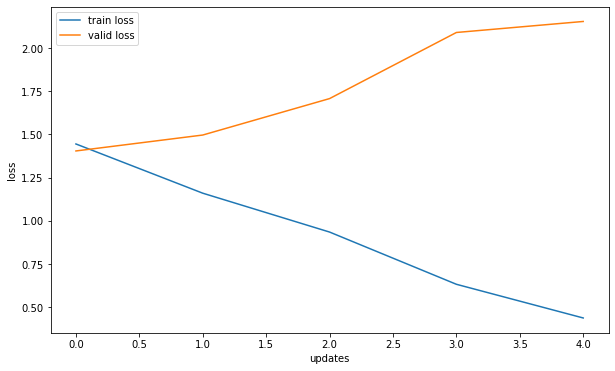

In [18]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(10, 6))
ax  = fig.add_subplot(1, 1, 1)
ax.plot(train_losses, label = 'train loss')
ax.plot(valid_losses, label = 'valid loss')
plt.legend()
ax.set_xlabel('updates')
ax.set_ylabel('loss')

Text(0, 0.5, 'acc')

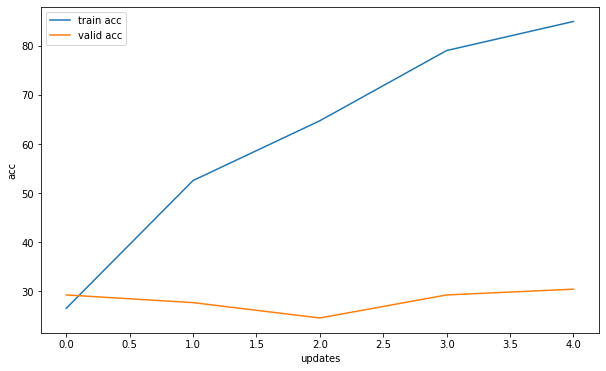

In [19]:
fig = plt.figure(figsize=(10, 6))
ax  = fig.add_subplot(1, 1, 1)
ax.plot(train_accs, label = 'train acc')
ax.plot(valid_accs, label = 'valid acc')
plt.legend()
ax.set_xlabel('updates')
ax.set_ylabel('acc')

## 4. Evaluation on test set

In [20]:
model.load_state_dict(torch.load('models/DEAP_BiLSTM.pt'))
test_loss, test_acc = evaluate(model, test_loader, criterion)

print(f'Test Loss: {test_loss:.3f} | Test Acc: {test_acc:.2f}%')

Test Loss: 1.417 | Test Acc: 30.47%


## Final Verdict



Hmm...so the accuracy is just slightly above chance (100 / 4 classes = 25%).   The reason for LSTM to perform poorly because taking each single sample point and tied them sequentially can be very ineffective, since each single sample point does not really mean anything.  In the next tutorial, we shall introduce a CONV1D + LSTM, which applies convolution first to capture some windowing average before applying to the LSTM.  